In [63]:
from network_processing import NetworkProcessor
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from animation import Animation
from time import sleep
from IPython.display import display, clear_output
from formation_codes_np import get_codes_pos_nos

Create a NetworkProcessor, which gets the generated formation codes and allow to do operations in order to build the network. (Change `team_id` to 1 to run the operations on the other team)

In [64]:
team_id = 0
net = NetworkProcessor(collapse_dead_edges=False, team=team_id)

Collapse all consecutive edges on the network into one edge with bigger weight. Add loops of size zero to all nodes that stays only on one keyframe in that state.

In [65]:
net_elab = net.collapse_loops().add_zero_loops()

New number of edges: 112580 - 103450 = 9130


Get the (log) distribution of the loop sizes and largest size.

In [66]:
loops_sizes, loops_sizes_distr = net_elab.loop_sizes.distr
mean = np.mean(net_elab.loop_sizes)
max_loop_size = loops_sizes[-1]
loops_distr_log = np.log(loops_sizes_distr)


Fit an exponential curve on the distribution of the loop sizes (first samples).

In [67]:

sample_fit = 20
median_log_val = np.median(loops_distr_log)
reg = LinearRegression().fit(loops_sizes[:sample_fit].reshape(-1, 1), loops_distr_log[:sample_fit])
exp = np.exp(reg.predict(loops_sizes.reshape(-1, 1)))
sorted_distr_log = np.sort(loops_distr_log)

median_log = loops_sizes[np.argsort(loops_distr_log)[np.argmax(median_log_val <= sorted_distr_log)]]

Plot the distribution of the loop sizes, the fitted log curve, the computed threshold and the mean loop size.

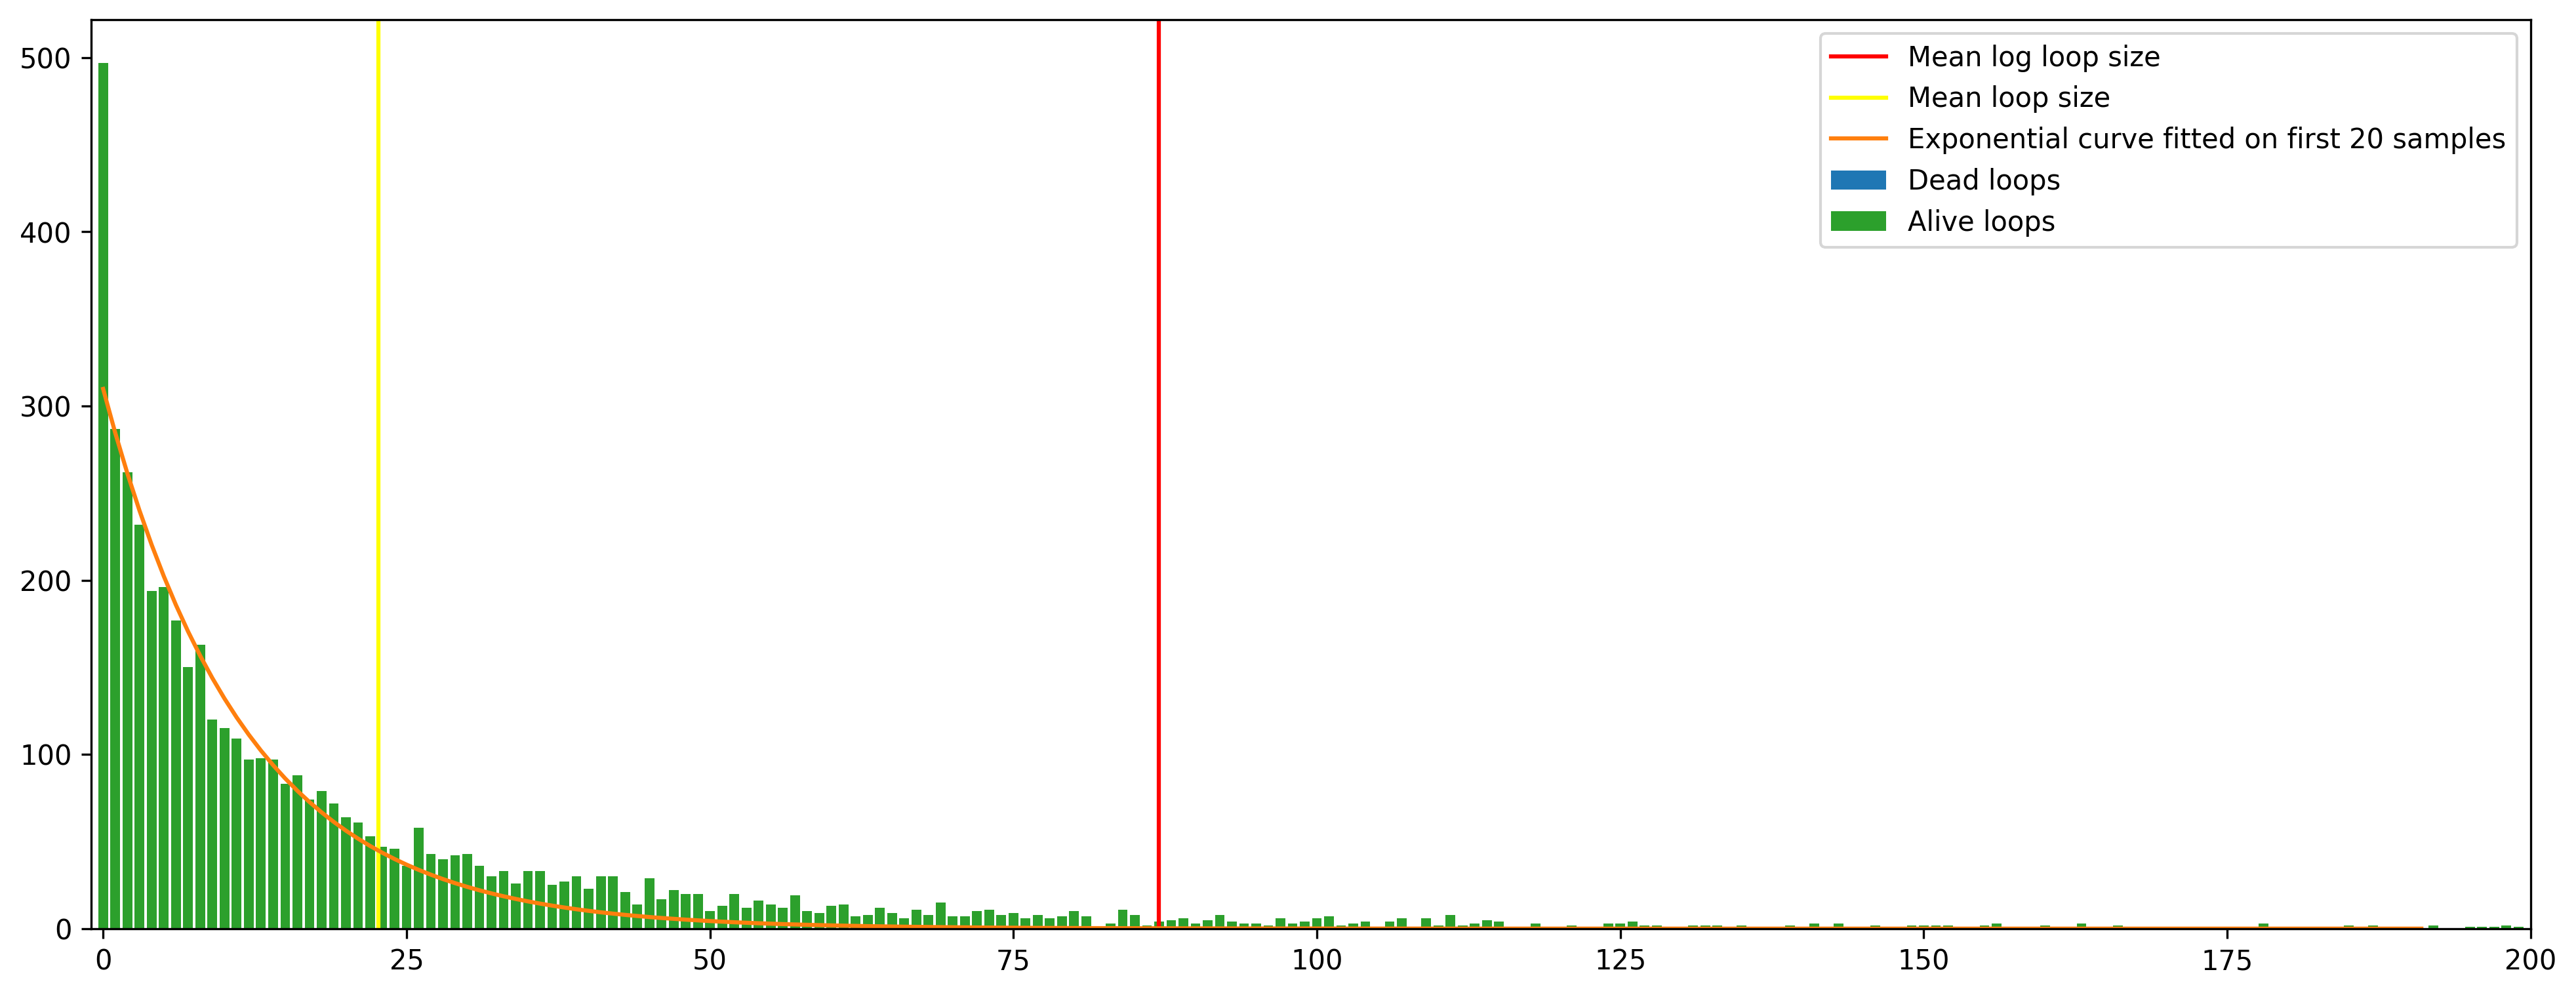

In [68]:
dead_loops_sizes, dead_loops_sizes_distr = net_elab.dead_loop_sizes.distr
alive_loops_sizes, alive_loops_sizes_distr = net_elab.alive_loop_sizes.distr


x = np.arange(max_loop_size+1)

d = np.zeros_like(x)
a = np.zeros_like(d)

d[dead_loops_sizes] = dead_loops_sizes_distr
a[alive_loops_sizes] = alive_loops_sizes_distr
plt.figure(figsize=(16, 6), dpi=300)
plt.xlim([-1,200])



plt.bar(x, d, label="Dead loops", color="tab:blue")
plt.bar(x, a, bottom=d, label="Alive loops", color="tab:green")
plt.axvline(median_log, color="red", label="Mean log loop size")
plt.axvline(mean, color="yellow", label="Mean loop size")
plt.plot(exp, color="tab:orange", label=f"Exponential curve fitted on first {sample_fit} samples")
plt.legend()
plt.show()

As we can see, the size of the loops follow more or less an exponential curve, with number of loops of size 0 beeing an outlier and flattening out slower towards high value. This shows that there are a lot of short-lived loops.
To see why there are so many loops of size 0, we can run the following animation that goes through all situations in which a formation exists for only one frame:


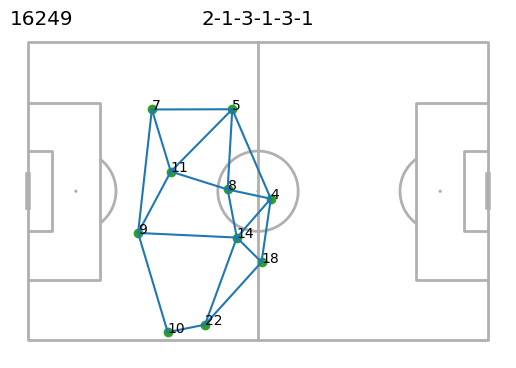

In [69]:
# See how the formations changes when states are short-lived.
# loop_size = 0 shows all the situations in which a formation exists for only one frame.
# Increase the value to see cases in which the formations last longer.
loop_size = 0
is_loop = net_elab.is_loop
cases = np.flatnonzero(is_loop & (net_elab.edges_weights == loop_size))

dt = 1
start = lambda kframe: kframe-dt
stop = lambda kframe: kframe+dt+loop_size+1
anim = Animation(t=team_id)
tstamps_cases = net_elab.edges_tstamps[cases, 0]
kframes = np.flatnonzero(np.isin(net_elab.tstamps, tstamps_cases))


try:
    for kframe in kframes:
        for _ in range(2):
            for i in range(start(kframe),stop(kframe)):
                anim.run(i)
                display(anim.fig)
                clear_output(wait=True)
                sleep(.25)
            sleep(1)
except KeyboardInterrupt:
    clear_output(wait=True)

clear_output(wait=True)



From the animation, we observe some reasons why these formations only last one frame:

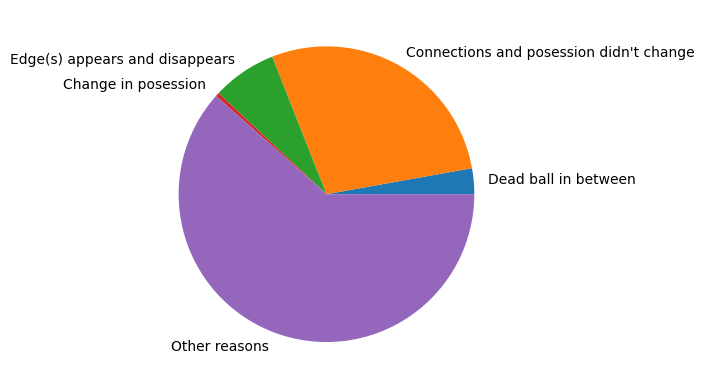

In [70]:
data, team_np = get_codes_pos_nos(threshold=150, t=team_id)
e = np.triu(data["edges"])

cases = np.flatnonzero(is_loop & (net_elab.edges_weights == 0))


tstamps_cases = net_elab.edges_tstamps[cases, 0]
tstamps_cases_before = net_elab.edges_tstamps[cases-1, 0]
tstamps_cases_after = net_elab.edges_tstamps[cases+1, 1]

dead_alive_jump = ~((tstamps_cases_before+1 == tstamps_cases)
                    & (tstamps_cases_after-1 == tstamps_cases))


posession = data["codes"][:,-1]
change_in_posession = ((posession[cases-1] != posession[cases]) | (posession[cases]!=posession[cases+1])) 


kframes = np.flatnonzero(np.isin(net_elab.tstamps, tstamps_cases))
same_connected = np.all(np.all((e[kframes] == e[kframes+1]) & (e[kframes] == e[kframes-1]), axis=1), axis=1) & ~change_in_posession
edge_app_and_disapp = (np.sum(np.sum(np.abs(e[kframes+1] - e[kframes-1]), axis=1), axis=1) == 0) & ~same_connected



pie = [
    [dead_alive_jump.sum(), "Dead ball in between"],
    [same_connected.sum(), "Connections and posession didn't change"],
    [edge_app_and_disapp.sum(), "Edge(s) appears and disappears"],
    [change_in_posession.sum(), "Change in posession"],
]

pie.append([len(cases) - sum([v for v,_ in pie]), "Other reasons"])


plt.pie([val for val,_ in pie], labels=[l for _,l in pie])
plt.show()




We now check the effect of choosing different thresholds on the amount of nodes generated in the new network.

In [71]:
thresholds = np.arange(1,max_loop_size+2)
n_nodes = np.zeros_like(thresholds)
n_nodes_collapse_dead = np.zeros_like(thresholds)
n_codes = np.zeros_like(thresholds)


for i, t in enumerate(thresholds):
    alive_only = net_elab.remove_loops(t, verbose=False)
    dead_too = net_elab.remove_loops(t, verbose=False, collapse_dead_edges=True)
    n_nodes[i] = alive_only.n_nodes
    n_nodes_collapse_dead[i] = dead_too.n_nodes

If we consider the plot of the decreasing number of nodes by increasing of the threshold, we can treat it as a ROC curve and therefore take the closest point to the origin as a good value for the threshold. We perform the distance measure on both normalized and unnormalized coordinates, using the number of nodes obtained from collapsing alive edges only.

In [72]:
# Normalize x, y data into [0,1], in order to find closest point to origin.
x = (thresholds-np.min(thresholds))/np.max(thresholds)
y = (n_nodes-np.min(n_nodes))/np.max(n_nodes)
distance_from_o_normalized = x**2 + y**2
distance_from_o = thresholds**2 + n_nodes**2
it_norm, it = np.argmin(distance_from_o_normalized), np.argmin(distance_from_o)
threshold_normalized = thresholds[it_norm]
threshold = thresholds[it]


These are the values we obtain:

In [73]:
def print_result(s, t, i):
    print(f"{s}: {t}. Resulting number of nodes: {n_nodes[i]} or {n_nodes_collapse_dead[i]} if we collapse dead too")
print_result("Normalized threshold", threshold_normalized, it_norm)
print_result("Unnormalized threshold", threshold, it)
mean_i = np.argmax(thresholds >= mean)
median_log_i = np.argmax(thresholds == median_log)

print_result("Mean as threshold", f"{mean:.02f}", mean_i)
print_result("Log median as threshold", median_log, median_log_i)


Normalized threshold: 76. Resulting number of nodes: 76 or 38 if we collapse dead too
Unnormalized threshold: 58. Resulting number of nodes: 85 or 58 if we collapse dead too
Mean as threshold: 22.70. Resulting number of nodes: 128 or 121 if we collapse dead too
Log median as threshold: 87. Resulting number of nodes: 73 or 33 if we collapse dead too


Plot the results.

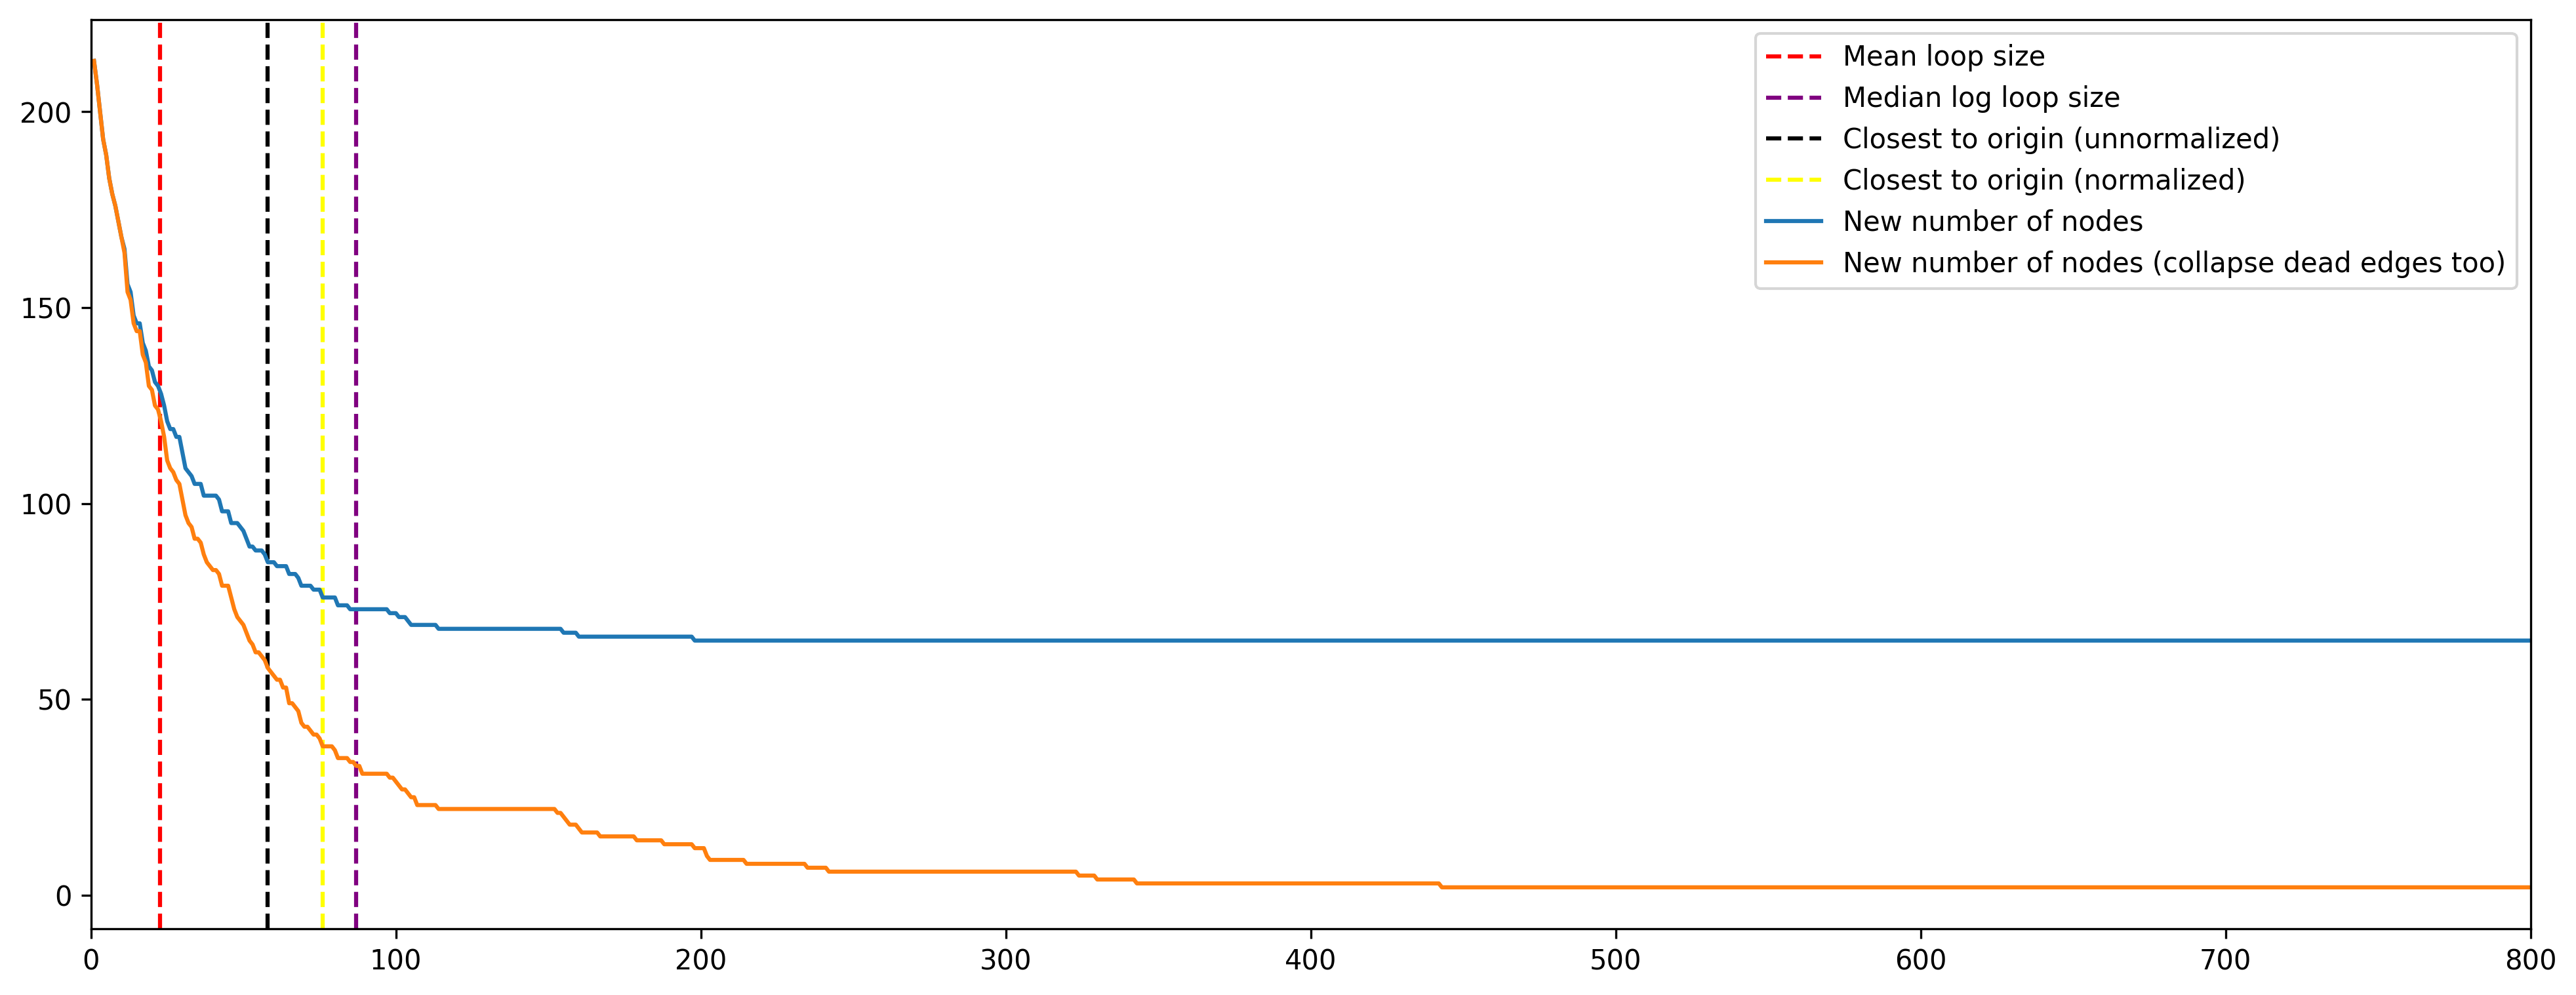

In [75]:

plt.figure(figsize=(16, 6), dpi=300)
plt.axvline(mean, color="red", linestyle="--", label="Mean loop size")
plt.axvline(median_log, color="purple", linestyle="--", label="Median log loop size")
plt.axvline(threshold, color="black", linestyle="--", label="Closest to origin (unnormalized)")
plt.axvline(threshold_normalized, color="yellow", linestyle="--", label="Closest to origin (normalized)")
plt.plot(thresholds, n_nodes, label="New number of nodes")
plt.plot(thresholds, n_nodes_collapse_dead, label="New number of nodes (collapse dead edges too)")
plt.xlim([0,800])
plt.legend()
plt.show()